# Lab 4 (Part B): Regularized Linear Regression

<div class="alert alert-block alert-danger">

__IMPORTANT__ 
Please complete this Jupyter Notebook file and upload it to blackboard __before 20 February 2020__.
</div>

In this part of the Lab, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance. During quality assurance, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

## Loading the data
This dataset is the same as the one you used previously in the Lab about kNN classification. We have a file `microchips-dataset.csv` which contains the dataset for our classification problem. The first column corresponds to the result of *"microchip test 1"*, the second column corresponds to the result of *"microchip test 2"*, and the third column is the class-label indicating if the microchip has been accepted or rejected (1 = Accepted, 0 = Rejected).

<img src="imgs/MicroshipDataLab3B.png" />

The following Python code loads the dataset from the csv file into the variables $X$ (input data matrix) and $y$ (output class-labels). The variable $X$ should be a matrix (as a numpy array) with $n$ lines and two columns (two feature) corresponding to *"microchip test 1"* and *"microchip test 2"*. The variable $y$ should be a numpy array of $n$ elements. Read the code and run it.

A visualisation of this dataset looks like follows:
<img src="imgs/MicroshipScatterPlotLab3B.png" width="500px" />

<IPython.core.display.Javascript object>


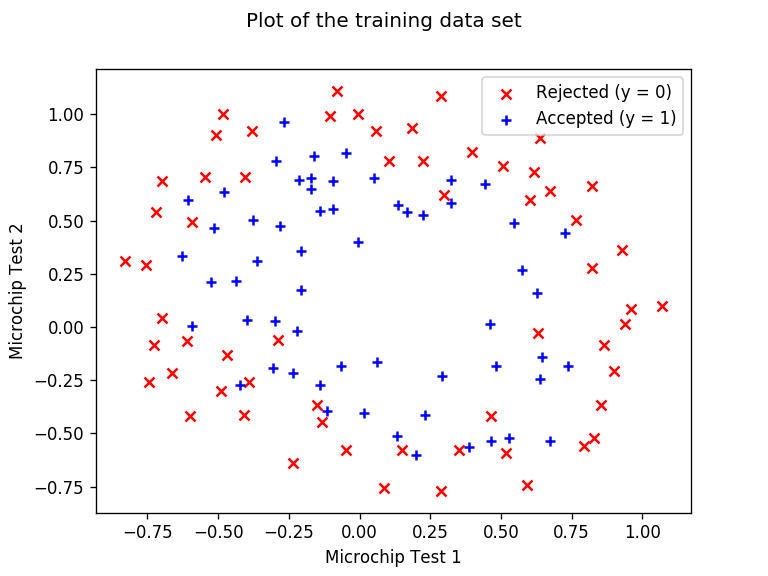

In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np

filename = "datasets/microchips-dataset.csv"
mydata = np.genfromtxt(filename, delimiter=",") #############################
n = len(mydata) # we have n data-points
X = mydata[:, :2] # input data matrix (with n lines and 2 columns)
y = mydata[:, -1] # vector of n outputs

""" TODO:
You can here visualize the dataset as in the previous figure.
"""
# find the array of X where class is 0
X0 = X[y == 0]
# array of X where class is 1
X1 = X[y == 1]
# create a figure to plot the values
fig, ax = plt.subplots()
#plot the scatterplot for class 0
ax.scatter(X0[:,0], X0[:,1], color="red", marker="x", label="Rejected (y = 0)")
# plot the scatterplot for class 1
ax.scatter(X1[:, 0], X1[:, 1], color="blue", marker="+", label="Accepted (y = 1)")
fig.suptitle("Plot of the training data set")
ax.set_xlabel("Microchip Test 1")
ax.set_ylabel("Microchip Test 2")
ax.legend()
fig.show()

## Feature mapping
From the previous visualization, you can see that our dataset cannot be separated into positive (class 1) and negative (class 0) examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary. As you might know, one way to fit the data better is to create more features from each data-point by mapping the features into polynomial terms of $x_1$ and $x_2$ (e.g. $x_1^2$, $x_1 x_2$, etc ...).

The following provided function `mapFeature(..)` maps the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power. As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector (including an additional first $1$, so you don't need to add it). So, for a 2-dimensional data-point $x \in \mathbb{R}^2$ from the dataset $X$, it's mapped version in the new dataset `X_poly` is as follows:
$$
\text{mapped version of $x$ is }
\begin{bmatrix}
1\\ 
x_1\\ 
x_2\\ 
x_1^2\\
x_1 x_2\\ 
x_2^2\\ 
x_1^3\\ 
\vdots\\ 
x_1 x_2^5\\ 
x_2^6
\end{bmatrix}
$$

A logistic regression classifier trained on this higher-dimension feature-vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot. While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the Lab, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

In [2]:
# Feature mapping function to polynomial features. This function Maps a dataset of two input 
# features X1, X2 (which must be of the same size) to quadratic features. Returns a new feature 
# array with more features, comprising of X1, X2, (X1**2), (X2**2), X1*X2, X1*(X2**2), etc..
def mapFeature(X1, X2):
    degree = 6
    col = 0
    out = np.ones((len(X1), 27))
    for i in range(1, degree+1):
        for j in range(0, i+1):
            out[:, col] = (X1**(i-j)) * (X2**j)
            col += 1
    
    out = np.c_[ np.ones(len(out)), out ] # add a first column of ones
    return out

# We call mapFeature on the original dataset X (with two features) to get a mapped 
# dataset X_poly with 28 features (which already includes a first column of ones).
X_poly = mapFeature(X[:, 0], X[:, 1])
print("Shape of X_poly is:", X_poly.shape)

""" TODO:
You can print here a small subset of X_poly to see how to looks like
"""
print(X_poly[:10])

Shape of X_poly is: (118, 28)
[[ 1.00000000e+00  5.12670000e-02  6.99560000e-01  2.62830529e-03
   3.58643425e-02  4.89384194e-01  1.34745327e-04  1.83865725e-03
   2.50892595e-02  3.42353606e-01  6.90798869e-06  9.42624411e-05
   1.28625106e-03  1.75514423e-02  2.39496889e-01  3.54151856e-07
   4.83255257e-06  6.59422333e-05  8.99809795e-04  1.22782870e-02
   1.67542444e-01  1.81563032e-08  2.47750473e-07  3.38066048e-06
   4.61305487e-05  6.29470940e-04  8.58939846e-03  1.17205992e-01]
 [ 1.00000000e+00 -9.27420000e-02  6.84940000e-01  8.60107856e-03
  -6.35227055e-02  4.69142804e-01 -7.97681228e-04  5.89122275e-03
  -4.35092419e-02  3.21334672e-01  7.39785525e-05 -5.46363780e-04
   4.03513411e-03 -2.98012201e-02  2.20094970e-01 -6.86091891e-06
   5.06708697e-05 -3.74226408e-04  2.76382476e-03 -2.04120477e-02
   1.50751849e-01  6.36295342e-07 -4.69931780e-06  3.47065055e-05
  -2.56322636e-04  1.89305413e-03 -1.39810280e-02  1.03255971e-01]
 [ 1.00000000e+00 -2.13710000e-01  6.9225000

## Cost function and gradient
Your task here is to complete the following Python code to compute the cost function and gradient for regularized logistic regression. Recall that the regularized cost function in logistic regression is as follows (note that you should not regularize the parameter $\theta_0$).
$$E(\theta) = \frac{1}{n} \sum_{i=1}^{n} \left [ -y^{(i)} \log{(h_\theta(x^{(i)}))} - (1 - y^{(i)}) \log{(1 - h_\theta(x^{(i)}))} \right ] + \frac{\lambda}{2n} \sum_{j=1}^{d} \theta_j^2$$

The gradient of the cost function is a vector where the $j^{th}$ element in this vector is defined as follows:
$$
\frac{\partial E(\theta)}{\partial \theta_0} = \frac{1}{n} \sum_{i=1}^{n} ( h_\theta(x^{(i)}) - y^{(i)} ) ~ x_j^{(i)}
\quad \quad \quad \quad \quad \quad \text{for } j = 0
$$

$$
\frac{\partial E(\theta)}{\partial \theta_j} = \left ( \frac{1}{n} \sum_{i=1}^{n} ( h_\theta(x^{(i)}) - y^{(i)} ) ~ x_j^{(i)} \right ) + \frac{\lambda}{n} \theta_j
\quad \quad \text{for } j \geq 1
$$

Once you are done, call your cost function $E(\theta)$ to test if it's working correctly using the initial value of $\theta$ (initialized to all zeros). You should see that the cost is about $0.693$.

In [1]:
# This sigmoid function works on a scalar value as well as a vector or a matrix
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def h(theta, x):
    return sigmoid(theta.T @ x)

def h_all(theta, X):
    return np.array([ h(theta, x) for x in X ])

""" TODO:
Write the definition of the cost function E(..) for regularized logistic regression. 
"""
def E(theta, X, y, lmd):
    return np.sum(-y@np.log(h_all(theta, X)) - (1 - y)@np.log(1 - h_all(theta, X)))/y.shape[0] + (lmd*np.sum(np.square(theta[1:])))/(2*X.shape[0])


""" TODO:
Write the definition of the corresponding gradient function gradE(..)
"""
def gradE(theta, X, y, lmd):
    grad = ((h_all(theta, X) - y)@X)/X.shape[0] + (lmd*theta)/X.shape[0]
    grad_without_penalty = ((h_all(theta, X) - y)@X)/X.shape[0]
    grad[0] = grad_without_penalty[0]
    return grad


""" TODO:
Call your cost function and gradient using the initial value of theta (initialized to all zeros) and lmd = 0
"""
theta_init = np.zeros(X_poly.shape[1])
print("Cost: ", E(theta_init, X_poly, y, 0))
print("Gradient vector: ", gradE(theta_init, X_poly, y, 0))


NameError: name 'np' is not defined

## Learning parameters using scipy.optimize.minimize(..)
Once you have completed the cost and gradient for regularized logistic regression correctly, you will use `scipy.optimize.minimize(..)` to learn the optimal parameters $\theta$. To do this, complete the definition of the function `trainLogisticReg(..)` in the following Python code. The function should return the optimal parameters vector $\theta$ that it finds.

In [4]:
import scipy.optimize as op

""" TODO:
Complete the definition of the function trainLogisticReg(...). You can use op.minimize(..) as in previous Labs.
"""
def trainLogisticReg(X, y, theta_init, lmd):
    # TODO: Use op.minimize(..) to minimize the cost function E, 
    res = op.minimize(E, theta_init, (X, y, lmd), 'TNC', gradE)
    # the optimal parameters can then be accessed with: theta = res.x
    return res.x


""" TODO:
Call the function trainLogisticReg(..) to check if it is working correctly. The final cost computed 
based on the optimal theta, should be smaller than the initial cost computed based on theta_init.
"""
theta_init = np.zeros(X_poly.shape[1])  # Some initial theta (of same dimension as the number of features)
lmd = 0  # The regularization parameter

print("Initial cost: ", E(theta_init, X_poly, y, lmd))
theta = trainLogisticReg(X_poly, y, theta_init, lmd)
print("Final cost: ", E(theta, X_poly, y, lmd))

Initial cost:  0.6931471805599454
Final cost:  0.25936394708806293


## Plotting the decision boundary
To help you visualize the model learned by this classifier, we have provided the function `trainAndPlotDecisionBoundary(..)` which trains a regularized logistic regression by calling the previously defined function `trainLogisticReg(..)`, then plots the (nonlinear) decision boundary that separates the positive and negative examples. In `trainAndPlotDecisionBoundary(..)`, we plot the nonlinear decision boundary by computing the classifier's predictions on an evenly spaced grid and then and drew a contour plot of where the predictions change from $y = 0$ to $y = 1$. You can read the code of this function before running it, but you don't have to fully understand all of it.

<IPython.core.display.Javascript object>


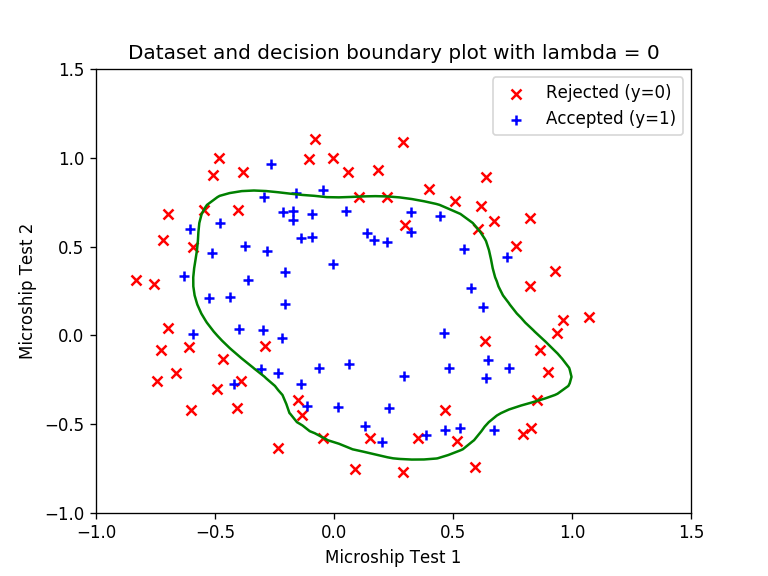

In [5]:
def trainAndPlotDecisionBoundary(X_original, X_poly, y, theta_init, lmd):
    # Training
    theta = trainLogisticReg(X_poly, y, theta_init, lmd)
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Microship Test 1")
    ax.set_ylabel("Microship Test 2")
    
    # Plotting the original dataset
    X0 = X_original[y==0]
    X1 = X_original[y==1]
    ax.scatter(X0[:, 0], X0[:, 1], color="red", marker="x", label="Rejected (y=0)")
    ax.scatter(X1[:, 0], X1[:, 1], color="blue", marker="+", label="Accepted (y=1)")
    
    # Plotting the nonlinear decision boundary
    x1_plot = np.linspace(-1, 1.5, 50)
    x2_plot = np.linspace(-1, 1.5, 50)
    X1_plot, X2_plot = np.meshgrid(x1_plot, x2_plot)
    
    z = np.zeros((len(x1_plot), len(x2_plot)))
    for i in range(len(x1_plot)):
        for j in range(len(x2_plot)):
            z[i][j] = mapFeature(x1_plot[i:i+1], x2_plot[j:j+1]) @ theta
            
    ax.contour(X1_plot, X2_plot, z, [0], colors="green")
    
    ax.set_title("Dataset and decision boundary plot with lambda = {}".format(lmd))
    ax.legend()
    fig.show()


# Here we call the function using the an initial theta of zeros, and lmd = 0 (no regularization):
trainAndPlotDecisionBoundary(X, X_poly, y, theta_init, lmd=0)

## Trying different values for the regularization parameter $\lambda$
In this section, you will get to try out different regularization parameters for the dataset to understand how regularization prevents overfitting. In the Python code below, you can call `trainAndPlotDecisionBoundary(..)` using $\lambda = 0$, $\lambda = 0.01$, $\lambda = 0.5$, $\lambda = 1$, $\lambda = 10$, and $\lambda = 100$ (you can try other values as well if you want).

Notice the changes in the decision boundary as you vary $\lambda$. With a small $\lambda$, you should find that the classifier gets most training examples correct, but draws a complicated boundary, thus overfitting the data. This is not a good decision boundary. With a larger $\lambda$, you should see a plot that shows a simpler decision boundary which still separates the positives and negatives fairly well. However, if $\lambda$ is set to a too high value, you will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data.

<IPython.core.display.Javascript object>


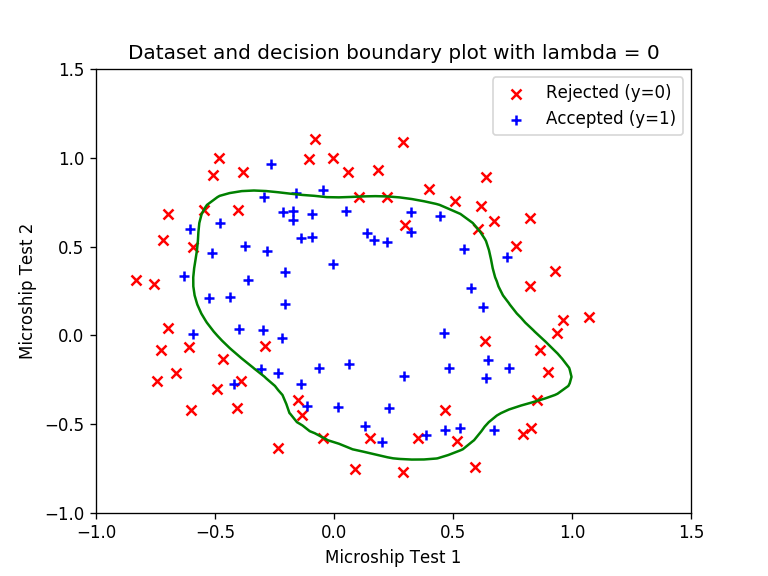

<IPython.core.display.Javascript object>


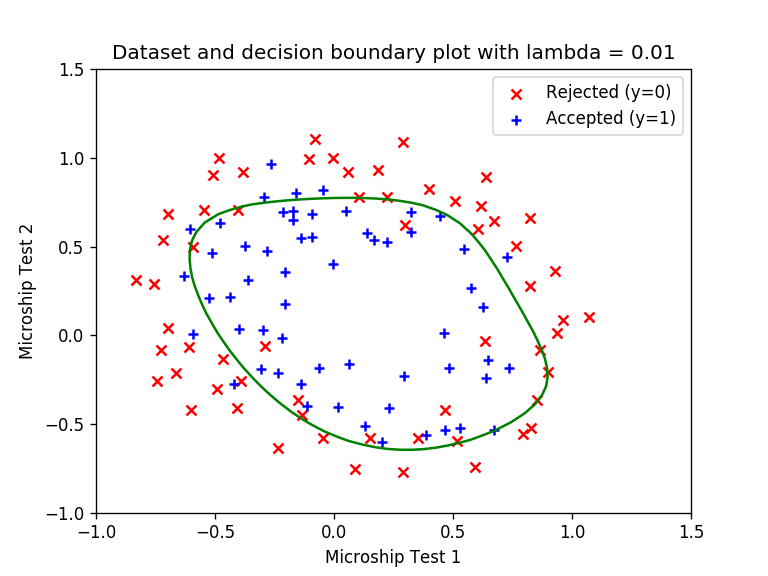

<IPython.core.display.Javascript object>


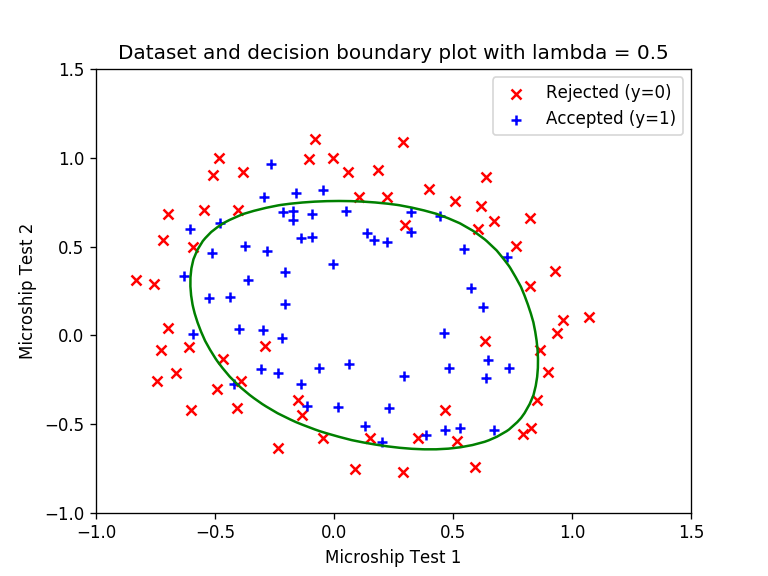

<IPython.core.display.Javascript object>


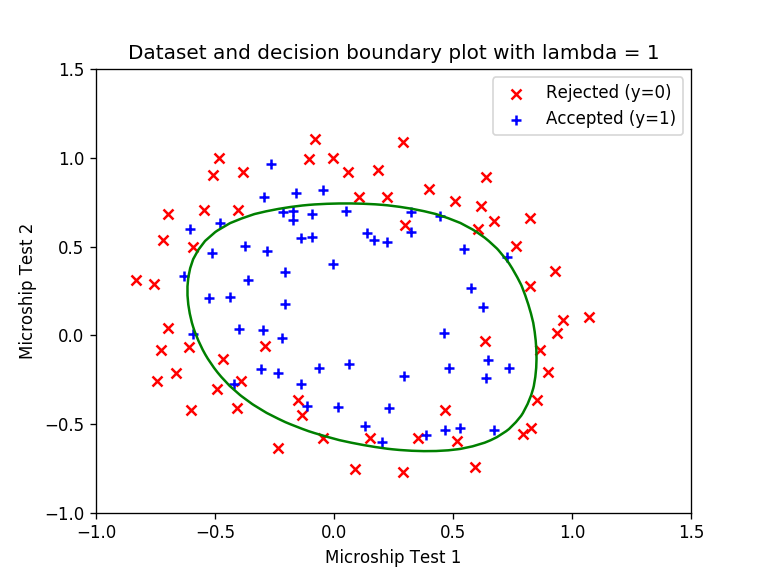

<IPython.core.display.Javascript object>


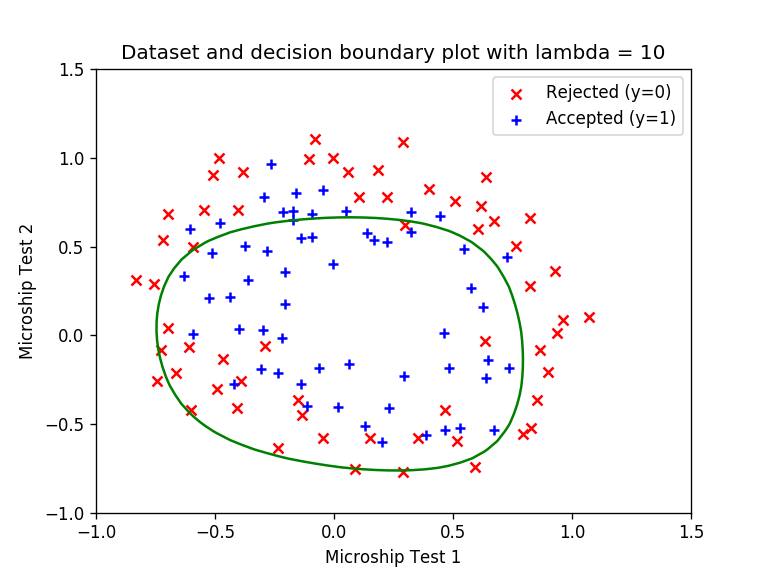

<IPython.core.display.Javascript object>


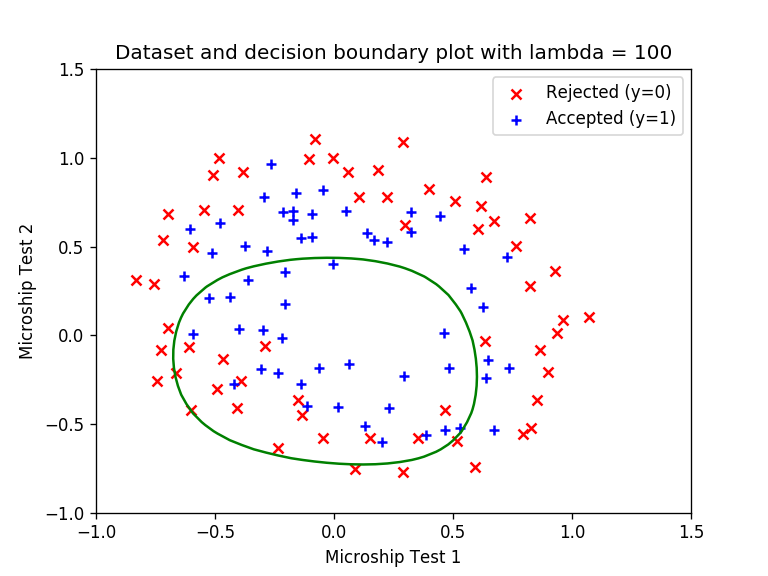

In [7]:
""" TODO:
Call the function trainAndPlotDecisionBoundary(..) with various values of lmd
"""
lmd_range = [0, 0.01, 0.5, 1, 10, 100]
for lmd in lmd_range:
    trainAndPlotDecisionBoundary(X, X_poly, y, theta_init, lmd)
# ...
# ...
# ...
# ...